# 2D-Multi-Lable CNN Classifier

## -------- Imports and Setup --------

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms

from sklearn.metrics import roc_auc_score, f1_score, roc_curve
import traceback

import medmnist
from medmnist import INFO
from medmnist.dataset import ChestMNIST

In [2]:
# --- Set device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------- Data Loading --------
def get_dataloaders(image_size=64, batch_size=32):
    transform = transforms.ToTensor()
    train_dataset = ChestMNIST(split="train", download=True, size=image_size, transform=transform)
    test_dataset = ChestMNIST(split="val", download=True, size=image_size, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_dataset, test_dataset, train_loader, test_loader

## -------- Model and Training --------

In [3]:
# -------- Model Definition --------
class ChestMNIST_CNN(nn.Module):
    def __init__(self, num_classes=14, image_size=64):
        super().__init__()
        
        channels = [32, 64]
        if image_size >= 64:
            channels += [128]
        if image_size >= 128:
            channels += [256]
        if image_size >= 224:
            channels += [512]

        layers = []
        in_channels = 1
        for out_channels in channels:
            layers += [
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(),
                nn.MaxPool2d(2),
                nn.Dropout(0.25),
            ]
            in_channels = out_channels

        self.conv_layers = nn.Sequential(*layers)

        # --- Dynamically compute flattened size ---
        with torch.no_grad():
            dummy = torch.zeros(1, 1, image_size, image_size)
            flat_size = self.conv_layers(dummy).view(1, -1).shape[1]

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flat_size, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.fc_layers(self.conv_layers(x))

# -------- Training and Evaluation --------
def train(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for x, y in loader:
        x, y = x.float().to(device), y.float().to(device)
        optimizer.zero_grad()
        loss = criterion(model(x), y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(loader)

def evaluate(model, loader, criterion, device, threshold=0.3, verbose=True, per_class_thresholds=None):
    model.eval()
    all_labels, all_probs = [], []
    running_loss = correct = total = 0
    
    with torch.no_grad():
        for x, y in loader:
            x, y = x.float().to(device), y.float().to(device)
            outputs = model(x)
            probs = torch.sigmoid(outputs)
            loss = criterion(outputs, y)
            running_loss += loss.item()
            
            if per_class_thresholds is not None:
                preds = probs > torch.tensor(per_class_thresholds).to(probs.device)
            else:
                preds = probs > threshold
                
            correct += (preds == y.bool()).sum().item()
            total += y.numel()
            all_labels.append(y.cpu())
            all_probs.append(probs.cpu())
            
    y_true = torch.cat(all_labels).numpy()
    y_prob = torch.cat(all_probs).numpy()
    y_pred = y_prob > (np.array(per_class_thresholds) if per_class_thresholds is not None else threshold)
    auc = roc_auc_score(y_true, y_prob, average='macro') if np.any(y_true) else float('nan')
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_micro = f1_score(y_true, y_pred, average='micro')
    
    if verbose:
        print(f"[Threshold: {'per-class' if per_class_thresholds is not None else threshold}]\n"
              f"F1 Macro: {f1_macro:.4f} | F1 Micro: {f1_micro:.4f}")
        
    return running_loss / len(loader), 100 * correct / total, auc, f1_macro, f1_micro

## -------- Helper Functions --------

In [4]:
def compute_pos_weights(dataset):
    labels = dataset.labels.astype(np.float32)
    pos_counts = labels.sum(axis=0)
    neg_counts = labels.shape[0] - pos_counts
    return torch.tensor(neg_counts / (pos_counts + 1e-5), dtype=torch.float)

def compute_optimal_thresholds(y_true, y_probs):
    thresholds = []
    for i in range(y_true.shape[1]):
        fpr, tpr, t = roc_curve(y_true[:, i], y_probs[:, i])
        best = t[np.argmax(tpr - fpr)]
        thresholds.append(best)
    return np.array(thresholds)

def save_best_model(model, optimizer, epoch, val_acc, best_acc, path):
    if val_acc > best_acc:
        print(f"Saving new best model... {val_acc:.2f}% > {best_acc:.2f}%")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_accuracy': val_acc
        }, path)
        return val_acc
    return best_acc

def plot_training_curves(train_losses, val_losses, val_accs, val_aucs=None, f1_macro=None, f1_micro=None):
    metrics = {'Loss': (train_losses, val_losses), 'Accuracy (%)': (val_accs,)}
    if val_aucs: metrics['AUC'] = (val_aucs,)
    if f1_macro: metrics['F1 Macro'] = (f1_macro,)
    if f1_micro: metrics['F1 Micro'] = (f1_micro,)
    plt.figure(figsize=(6 * len(metrics), 5))
    for i, (title, data) in enumerate(metrics.items(), 1):
        plt.subplot(1, len(metrics), i)
        for d in data:
            plt.plot(range(1, len(d)+1), d)
        plt.title(title)
        plt.xlabel("Epoch")
        plt.grid(True)
    plt.tight_layout()
    plt.show()

def print_training_history(train_losses, val_losses, val_acc):
    for i in range(len(train_losses)):
        print(f"Epoch {i+1}: Train Loss={train_losses[i]:.4f}, Val Loss={val_losses[i]:.4f}, Acc={val_acc[i]:.2f}%")

# -------- Training Loop --------
def run_training_loop(model, train_loader, test_loader, optimizer, criterion,
                      device, size=64, n_epochs=50, use_optimal_thresholds=False):
    
    save_path = f"best_model_{size}.pth"
    threshold_path = f"thresholds_{size}.npy"
    best_acc = 0.0
    train_losses, val_losses, accs, aucs, f1_macros, f1_micros = [], [], [], [], [], []

    for epoch in range(n_epochs):
        train_loss = train(model, train_loader, optimizer, criterion, device)
        val_loss, acc, auc, f1_macro, f1_micro = evaluate(
            model, test_loader, criterion, device, threshold=0.3, verbose=False
        )

        best_acc = save_best_model(model, optimizer, epoch, acc, best_acc, save_path)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        accs.append(acc)
        aucs.append(auc)
        f1_macros.append(f1_macro)
        f1_micros.append(f1_micro)

        print(f"Epoch {epoch+1}/{n_epochs} | TL: {train_loss:.4f} | VL: {val_loss:.4f} | "
              f"Acc: {acc:.2f}% | AUC: {auc:.4f} | F1M: {f1_macro:.4f} | F1μ: {f1_micro:.4f}")

    # --- Compute and save optimal thresholds ---
    optimal_thresholds = None
    if use_optimal_thresholds:
        model.eval()
        all_labels = []
        all_probs = []
        with torch.no_grad():
            for x, y in test_loader:
                x = x.float().to(device)
                y = y.float()
                outputs = model(x)
                probs = torch.sigmoid(outputs)
                all_labels.append(y)
                all_probs.append(probs.cpu())

        y_true = torch.cat(all_labels).numpy()
        y_probs = torch.cat(all_probs).numpy()
        optimal_thresholds = compute_optimal_thresholds(y_true, y_probs)

        # --- Save thresholds ---
        np.save(threshold_path, optimal_thresholds)

        # --- Re-evaluate with thresholds ---
        val_loss, acc, auc, f1_macro, f1_micro = evaluate(
            model, test_loader, criterion, device,
            per_class_thresholds=optimal_thresholds, verbose=True
        )

        print(f"\n[Using Optimal Thresholds for size {size}]")
        print(f"Val Acc: {acc:.2f}% | AUC: {auc:.4f} | "
              f"F1 Macro: {f1_macro:.4f} | F1 Micro: {f1_micro:.4f}")

    return train_losses, val_losses, accs, aucs, f1_macros, f1_micros, optimal_thresholds

## -------- Run Training for Multiple Sizes --------


===== Training for image size 28x28 =====
Using downloaded and verified file: C:\Users\odog2\.medmnist\chestmnist.npz
Using downloaded and verified file: C:\Users\odog2\.medmnist\chestmnist.npz
Saving new best model... 66.86% > 0.00%
Epoch 1/100 | TL: 0.7555 | VL: 0.7131 | Acc: 66.86% | AUC: 0.6597 | F1M: 0.1152 | F1μ: 0.1884
Epoch 2/100 | TL: 0.7296 | VL: 0.7014 | Acc: 58.19% | AUC: 0.6890 | F1M: 0.1093 | F1μ: 0.1720
Epoch 3/100 | TL: 0.7190 | VL: 0.6929 | Acc: 61.89% | AUC: 0.6932 | F1M: 0.1166 | F1μ: 0.1818
Epoch 4/100 | TL: 0.7125 | VL: 0.6842 | Acc: 66.69% | AUC: 0.7024 | F1M: 0.1265 | F1μ: 0.1967
Epoch 5/100 | TL: 0.7090 | VL: 0.6853 | Acc: 62.81% | AUC: 0.7083 | F1M: 0.1237 | F1μ: 0.1862
Epoch 6/100 | TL: 0.7048 | VL: 0.6916 | Acc: 59.18% | AUC: 0.7118 | F1M: 0.1202 | F1μ: 0.1761
Epoch 7/100 | TL: 0.7011 | VL: 0.7052 | Acc: 54.49% | AUC: 0.7072 | F1M: 0.1111 | F1μ: 0.1629
Epoch 8/100 | TL: 0.6969 | VL: 0.6754 | Acc: 66.45% | AUC: 0.7192 | F1M: 0.1307 | F1μ: 0.1977
Epoch 9/100 |

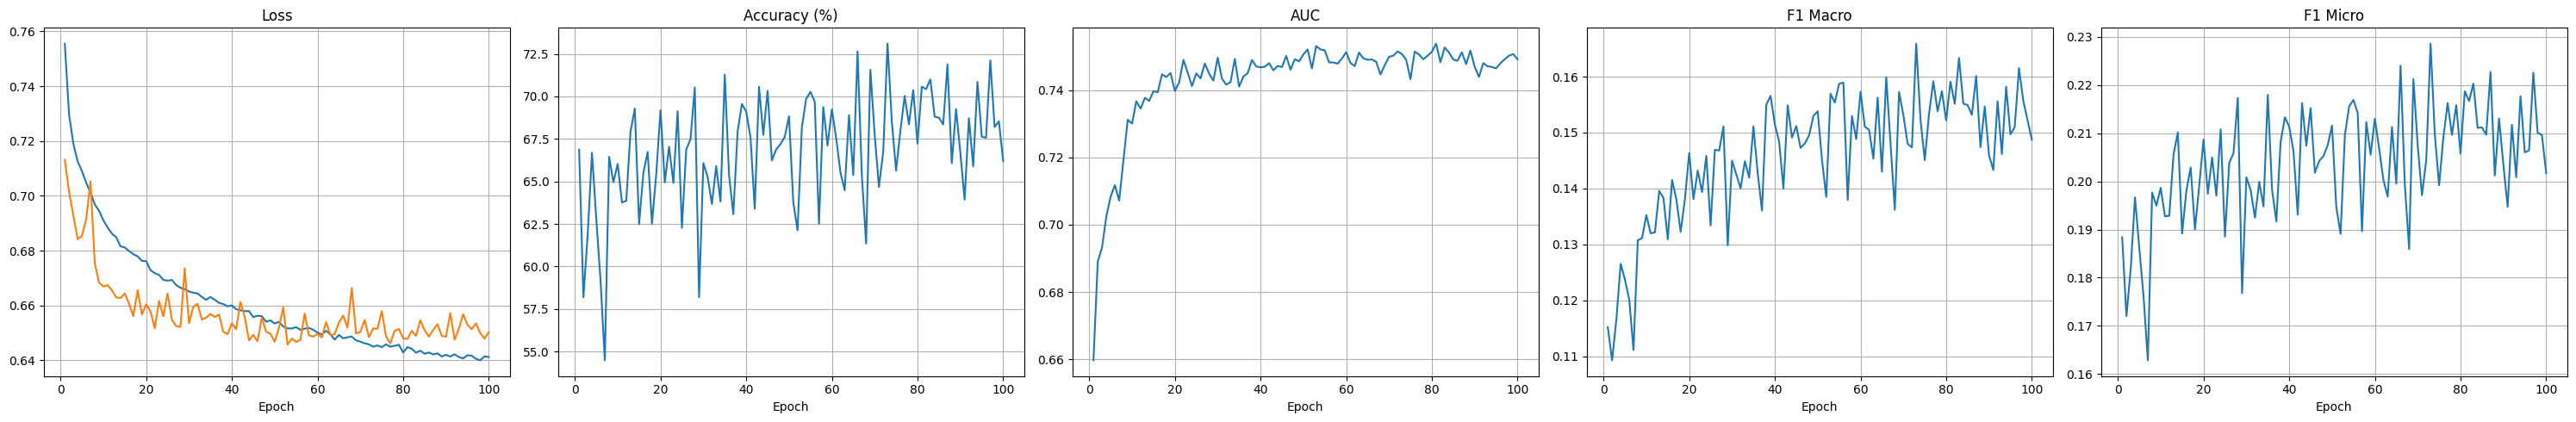


===== Training for image size 64x64 =====
Using downloaded and verified file: C:\Users\odog2\.medmnist\chestmnist_64.npz
Using downloaded and verified file: C:\Users\odog2\.medmnist\chestmnist_64.npz
Saving new best model... 57.99% > 0.00%
Epoch 1/100 | TL: 0.7666 | VL: 0.7150 | Acc: 57.99% | AUC: 0.6625 | F1M: 0.1011 | F1μ: 0.1674
Saving new best model... 58.68% > 57.99%
Epoch 2/100 | TL: 0.7363 | VL: 0.7079 | Acc: 58.68% | AUC: 0.6775 | F1M: 0.1069 | F1μ: 0.1710
Saving new best model... 63.52% > 58.68%
Epoch 3/100 | TL: 0.7268 | VL: 0.6957 | Acc: 63.52% | AUC: 0.6934 | F1M: 0.1146 | F1μ: 0.1853
Saving new best model... 66.81% > 63.52%
Epoch 4/100 | TL: 0.7221 | VL: 0.6926 | Acc: 66.81% | AUC: 0.6959 | F1M: 0.1176 | F1μ: 0.1921
Epoch 5/100 | TL: 0.7160 | VL: 0.6894 | Acc: 66.53% | AUC: 0.6937 | F1M: 0.1178 | F1μ: 0.1943
Saving new best model... 71.64% > 66.81%
Epoch 6/100 | TL: 0.7122 | VL: 0.6851 | Acc: 71.64% | AUC: 0.7051 | F1M: 0.1290 | F1μ: 0.2117
Epoch 7/100 | TL: 0.7096 | VL: 

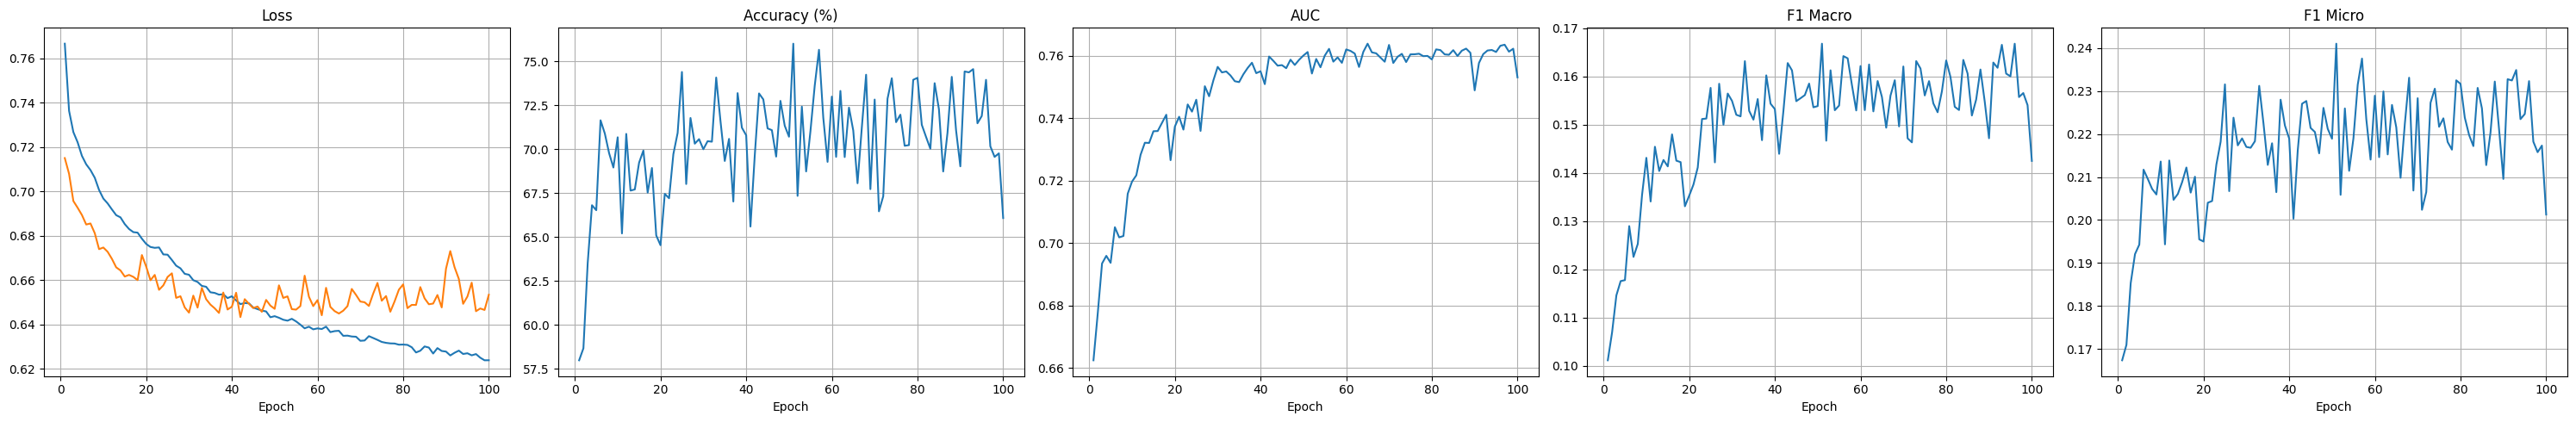


===== Training for image size 128x128 =====
Using downloaded and verified file: C:\Users\odog2\.medmnist\chestmnist_128.npz
Using downloaded and verified file: C:\Users\odog2\.medmnist\chestmnist_128.npz
Saving new best model... 55.51% > 0.00%
Epoch 1/100 | TL: 0.7901 | VL: 0.7340 | Acc: 55.51% | AUC: 0.6178 | F1M: 0.0991 | F1μ: 0.1618
Saving new best model... 59.38% > 55.51%
Epoch 2/100 | TL: 0.7492 | VL: 0.7268 | Acc: 59.38% | AUC: 0.6272 | F1M: 0.0824 | F1μ: 0.1689
Saving new best model... 59.98% > 59.38%
Epoch 3/100 | TL: 0.7410 | VL: 0.7225 | Acc: 59.98% | AUC: 0.6252 | F1M: 0.0827 | F1μ: 0.1703
Saving new best model... 63.90% > 59.98%
Epoch 4/100 | TL: 0.7376 | VL: 0.7125 | Acc: 63.90% | AUC: 0.6345 | F1M: 0.0881 | F1μ: 0.1815
Epoch 5/100 | TL: 0.7357 | VL: 0.7226 | Acc: 59.83% | AUC: 0.6397 | F1M: 0.0828 | F1μ: 0.1706
Saving new best model... 66.02% > 63.90%
Epoch 6/100 | TL: 0.7340 | VL: 0.7052 | Acc: 66.02% | AUC: 0.6488 | F1M: 0.0925 | F1μ: 0.1896
Epoch 7/100 | TL: 0.7326 | 

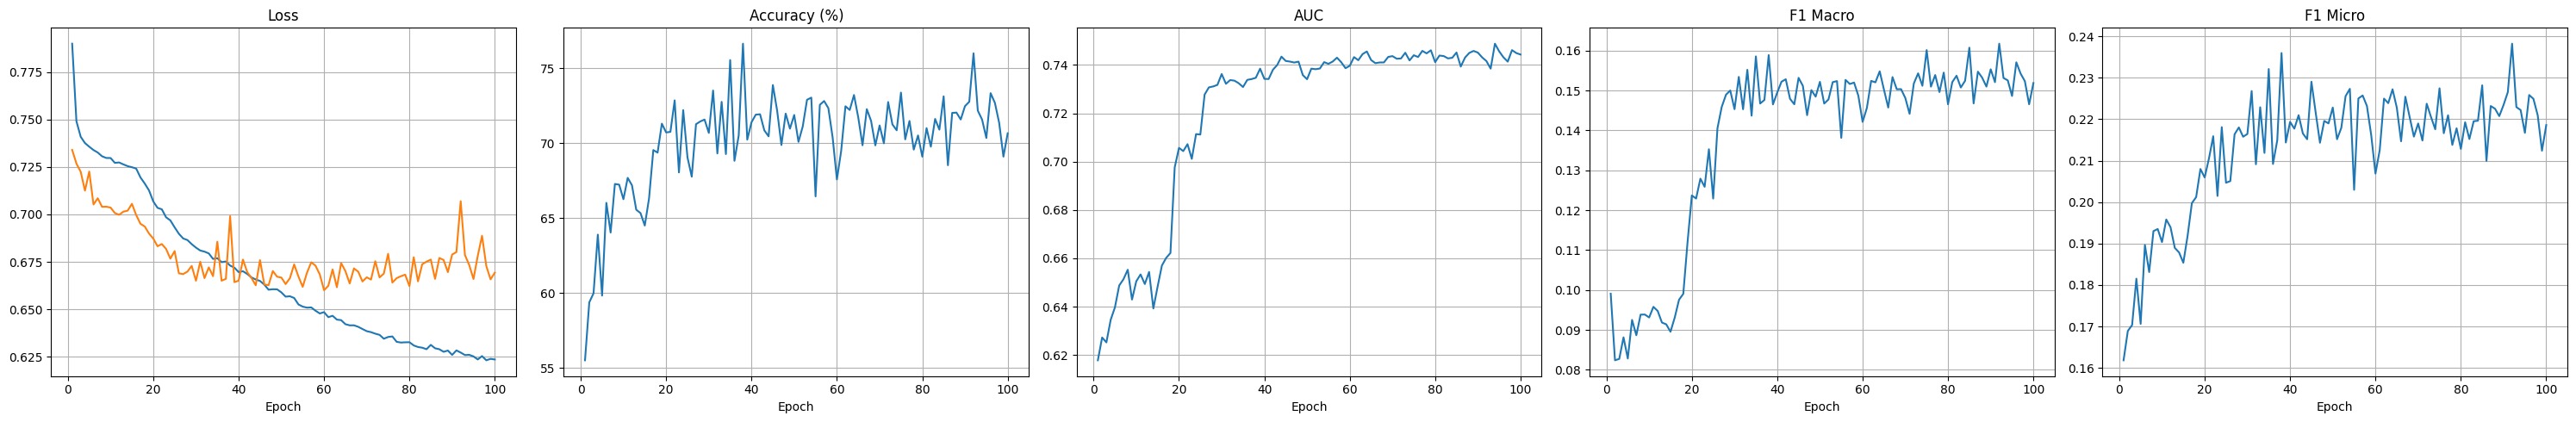


===== Training for image size 224x224 =====
Using downloaded and verified file: C:\Users\odog2\.medmnist\chestmnist_224.npz
Using downloaded and verified file: C:\Users\odog2\.medmnist\chestmnist_224.npz
Saving new best model... 54.59% > 0.00%
Epoch 1/100 | TL: 0.8087 | VL: 0.7616 | Acc: 54.59% | AUC: 0.5863 | F1M: 0.0769 | F1μ: 0.1562
Saving new best model... 61.24% > 54.59%
Epoch 2/100 | TL: 0.7562 | VL: 0.7330 | Acc: 61.24% | AUC: 0.6070 | F1M: 0.0838 | F1μ: 0.1725
Epoch 3/100 | TL: 0.7508 | VL: 0.7303 | Acc: 60.80% | AUC: 0.6121 | F1M: 0.0829 | F1μ: 0.1719
Epoch 4/100 | TL: 0.7489 | VL: 0.7344 | Acc: 57.97% | AUC: 0.6091 | F1M: 0.0805 | F1μ: 0.1654
Epoch 5/100 | TL: 0.7465 | VL: 0.7300 | Acc: 57.60% | AUC: 0.6253 | F1M: 0.0803 | F1μ: 0.1640
Epoch 6/100 | TL: 0.7456 | VL: 0.7285 | Acc: 59.01% | AUC: 0.6361 | F1M: 0.0817 | F1μ: 0.1681
Saving new best model... 63.87% > 61.24%
Epoch 7/100 | TL: 0.7446 | VL: 0.7210 | Acc: 63.87% | AUC: 0.6328 | F1M: 0.0869 | F1μ: 0.1812
Epoch 8/100 | T

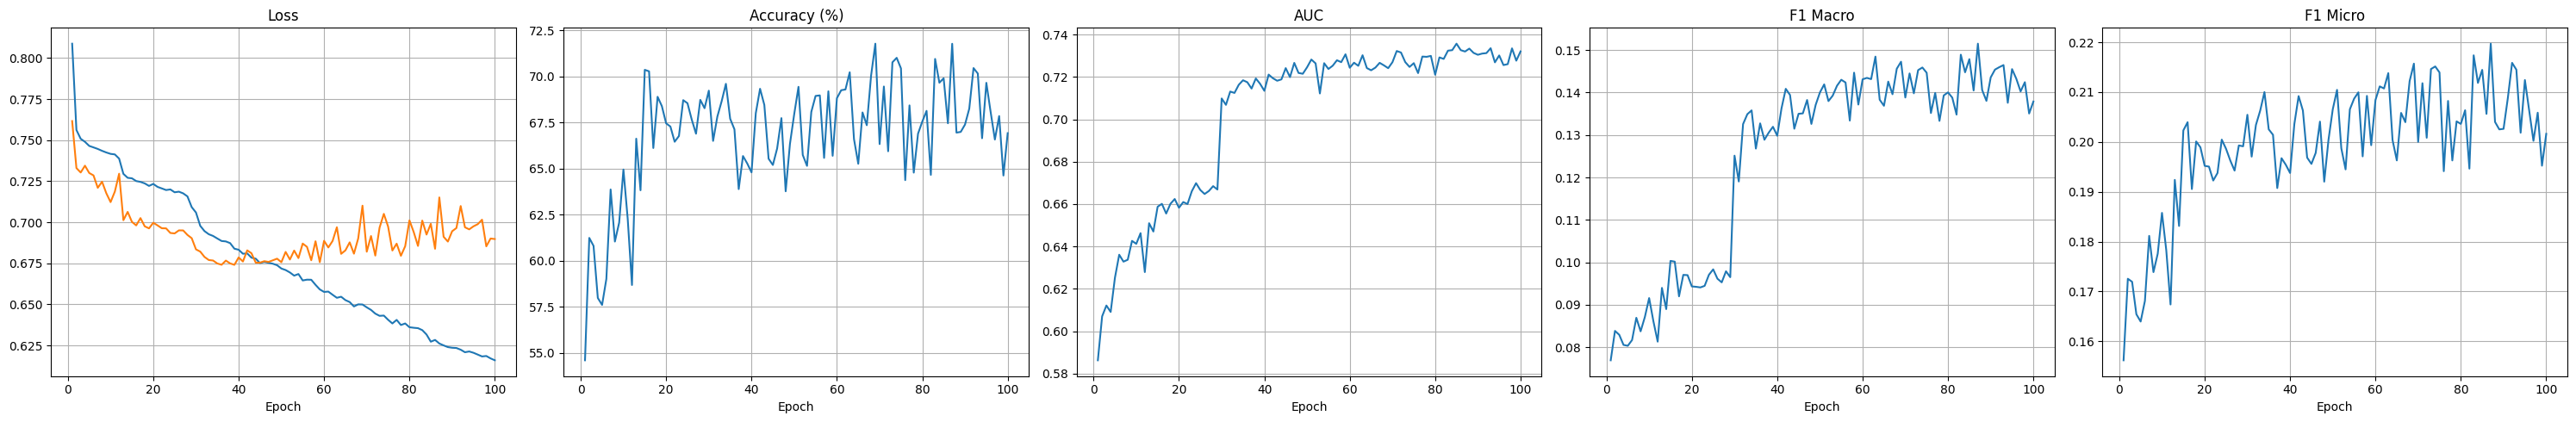

In [5]:
image_sizes = [28, 64, 128, 224]
epochs = 100
results = {}

for size in image_sizes:
    print(f"\n===== Training for image size {size}x{size} =====")
    
    train_ds, test_ds, train_loader, test_loader = get_dataloaders(image_size=size)
    model = ChestMNIST_CNN(image_size=size).to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    raw_weights = compute_pos_weights(train_ds)
    capped_weights = torch.clamp(raw_weights, max=10.0).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=capped_weights)

    threshold_path = f"thresholds_{size}.npy"

    if os.path.exists(threshold_path):
        print(f"Loading existing thresholds from: {threshold_path}")
        optimal_thresholds = np.load(threshold_path)
        run_training = False
    else:
        run_training = True

    if run_training:
        # --- Train and compute thresholds ---
        train_losses, val_losses, val_accs, val_aucs, f1_macros, f1_micros, optimal_thresholds = run_training_loop(
            model, train_loader, test_loader, optimizer, criterion,
            device, size=size, n_epochs=epochs, use_optimal_thresholds=True
        )
    else:
        # --- Just evaluate using saved thresholds ---
        checkpoint = torch.load(f"best_model_{size}.pth")
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        # --- Dummy run to get metrics ---
        train_losses, val_losses, val_accs, val_aucs, f1_macros, f1_micros = [], [], [], [], [], []
        evaluate(model, test_loader, criterion, device, per_class_thresholds=optimal_thresholds, verbose=True)

    # --- Store results ---
    results[size] = {
        "train_loss": train_losses,
        "val_loss": val_losses,
        "val_accuracy": val_accs,
        "val_auc": val_aucs,
        "val_f1_macro": f1_macros,
        "val_f1_micro": f1_micros,
        "optimal_thresholds": optimal_thresholds.tolist() if optimal_thresholds is not None else None
    }

    plot_training_curves(train_losses, val_losses, val_accs, val_aucs, f1_macros, f1_micros)

---